In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

Text(0, 0.5, 'Passengers')

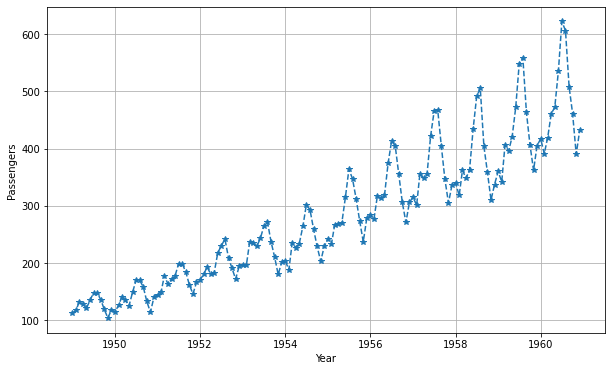

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df["Month"] = pd.to_datetime(df["Month"]) #convert column to datetime
df.set_index("Month", inplace=True)
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers,'--', marker='*')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')

In [ ]:
#check for missing values
df.isnull().values.any()#There are no missing values in our dataset however, in bid to explain how we handle 

#missing values, we will make a copy of our dataset and delete some values at random.

False

**Creating a copy of dataframe**

In [ ]:
df_copy = df.copy()
fraction = df_copy.sample(frac=0.1, random_state=0)
fraction['Passengers'] = np.nan
df_copy.loc[fraction.index, 'Passengers'] = fraction['Passengers']
df_copy.isnull().sum()
#There are now 14 missing values in the datase

Passengers    14
dtype: int64

**Filling missing values with imputation**

In [ ]:
#Filling missing data by imputation - Forward fill
df_copy_ffill = df_copy.fillna(method='ffill')
df_copy_ffill.isnull().sum()


Passengers    0
dtype: int64

In [ ]:
#Filling missing data by imputation - Backward fill
df_copy_bfill = df_copy.fillna(method='bfill')
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

**Filling missing values by interpolation**

In [ ]:
#Filling missing data by interpolation
df_copy_LIF = df_copy.interpolate(method='linear', limit_direction='forward')
df_copy_LIF.isnull().sum()
df_copy_LIB = df_copy.interpolate(method='linear', limit_direction='backward')
df_copy_LIB.isnull().sum()



Passengers    0
dtype: int64

**moving average**

In [ ]:
df_MA = df.copy()
MA = df_MA['Passengers'].rolling(5).mean()

**Time Series Specific Exploratory Methods**

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


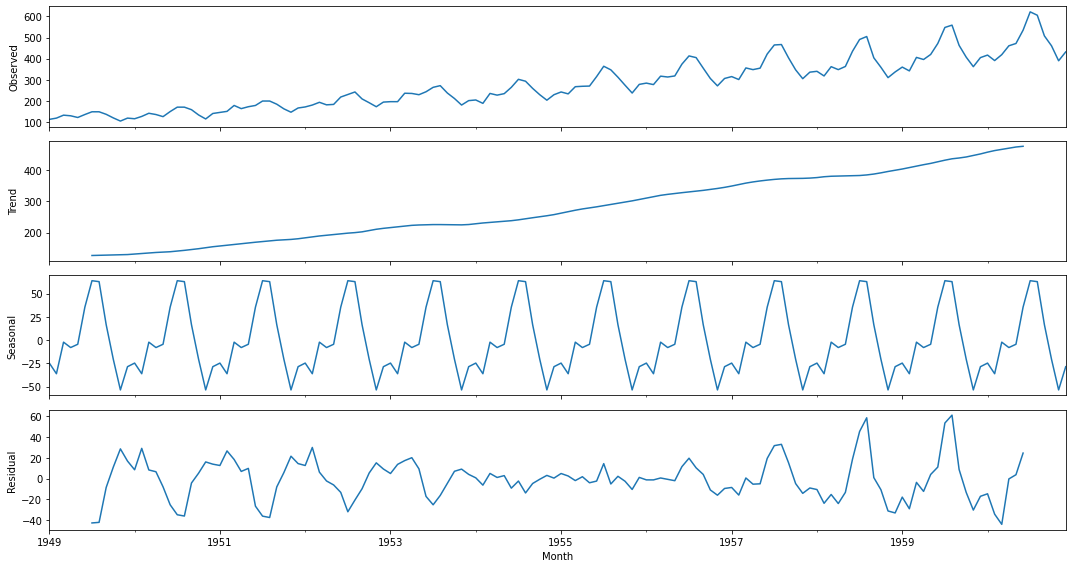

In [4]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df['Passengers'], model='additive')
decompose_series.plot()
plt.show()

#The decomposed time series show an obvious increasing trend and seasonality variations. 
#Recall that we have initially plotted the moving average on the last 12 months which showed that it varies with time. 
#This suggests that the data is not stationary. We will now perform an ADF test to confirm this speculation



In [85]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Passengers'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'   {k}: {v}') 

ADF Statistic: 0.815368879206047
p-value: 0.991880243437641
No. of lags used: 13
No. of observations used : 130
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598


In [ ]:
#From the results obtained, the p-value is greater than the critical value at a 5% significance level 
#and the ADF statistic is greater than any of the critical values obtained. 
#This confirms that the series is indeed non-stationary.
#Convert time series to stationary by removing trend and seasonality
#Transformation and Differencing
df_log = np.log(df)
df_diff = df_log.diff(periods=1)
plt.plot(df_diff.index, df_diff.Passengers, '-')
plt.plot(df_diff.rolling(12).mean(), color='red')

**Resampling**

In [117]:
#Downsample to quarterly data points
df_quarterly = df.resample('3M').mean()

#Upsample to daily data points
df_daily = df.resample('D').mean()

**Time-Series forecastng using stochastics**

**AR model**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


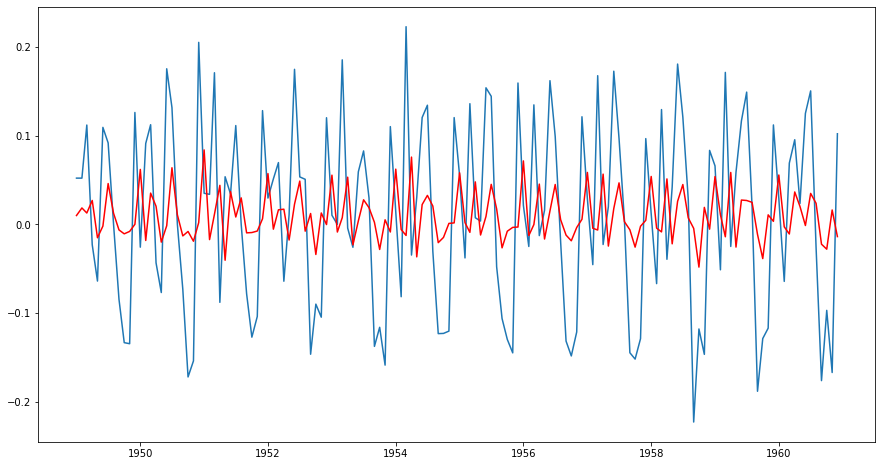

In [24]:
from statsmodels.tsa.arima_model import ARIMA
#(p,d,q)
df_diff = df_diff.fillna(method = 'bfill')
AR_model = ARIMA(df_diff, order=(2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color='red')

**MA model**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


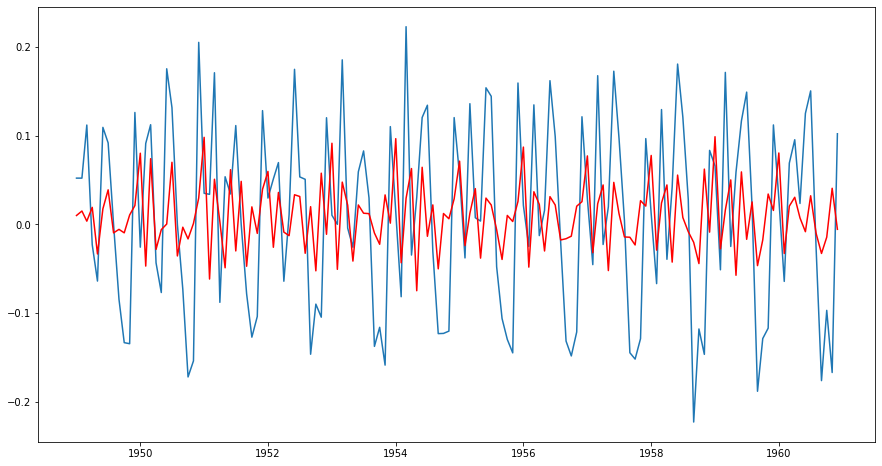

In [29]:
MA_model = ARIMA(df_diff, order=(0,0,2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color='red')


**ARIMA model**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


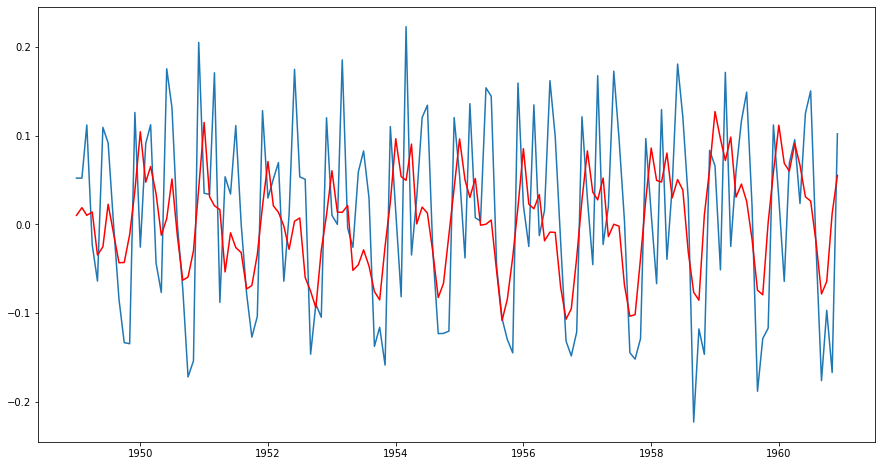

In [31]:
ARIMA_model = ARIMA(df_diff, order=(2,0,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color='red')

**ACF and PACF**

<Figure size 720x144 with 0 Axes>

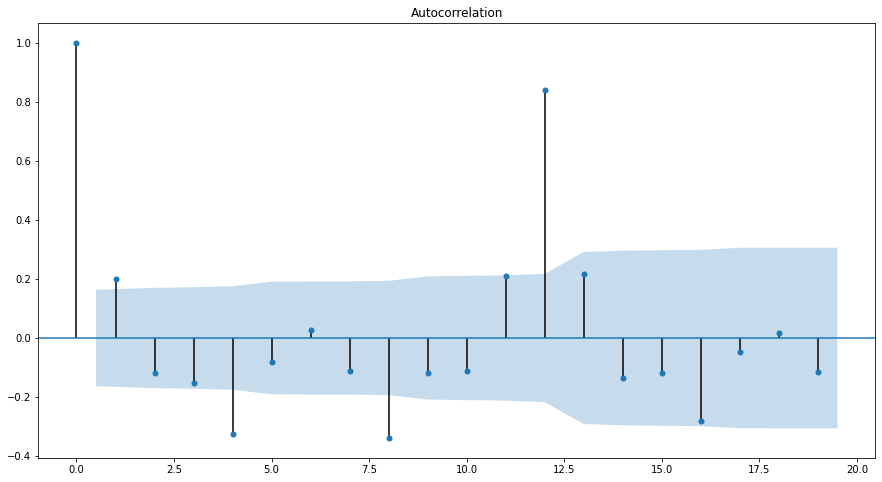

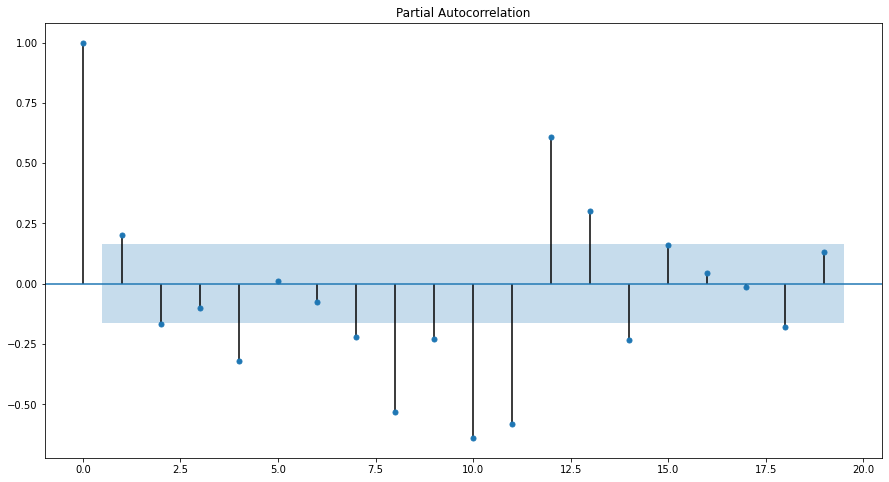

In [32]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ACF
plt.figure(figsize=(10,2))
plot_acf(df_diff, lags = range(0, 20))
plt.show()
#PACF
plot_pacf(df_diff, lags = range(0, 20))
plt.show()
#The shaded regions in the plots are the confidence intervals. 
#The lags where the PACF and ACF charts cross this region are the values for p and q respectively. 
#In both plots, #p=q=1.

**Time Series at Scale**

In [35]:
from fbprophet import Prophet
df=pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df['Month']= pd.to_datetime(df['Month'])
df = df.rename(columns={"Month": "ds", "Passengers": "y"})
df.head(10)

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
5,1949-06-01,135
6,1949-07-01,148
7,1949-08-01,148
8,1949-09-01,136
9,1949-10-01,119


In [34]:
model = Prophet()
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
#predict for the next 10 months
future = model.make_future_dataframe(periods=10, freq='M') 
forecast = model.predict(future) 
forecast.head()
#yhat is the prediction while yhat_lower and yhat_upper are the upper and lower boundaries


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,106.727984,55.519842,112.260700,106.727984,106.727984,-21.920631,-21.920631,-21.920631,-21.920631,-21.920631,-21.920631,0.0,0.0,0.0,84.807353
1,1949-02-01,108.901201,49.221305,105.901957,108.901201,108.901201,-30.682847,-30.682847,-30.682847,-30.682847,-30.682847,-30.682847,0.0,0.0,0.0,78.218354
2,1949-03-01,110.864107,81.302614,140.383862,110.864107,110.864107,-0.502710,-0.502710,-0.502710,-0.502710,-0.502710,-0.502710,0.0,0.0,0.0,110.361397
3,1949-04-01,113.037323,76.567432,135.866775,113.037323,113.037323,-5.185501,-5.185501,-5.185501,-5.185501,-5.185501,-5.185501,0.0,0.0,0.0,107.851823
4,1949-05-01,115.140437,83.051580,141.050410,115.140437,115.140437,-3.788702,-3.788702,-3.788702,-3.788702,-3.788702,-3.788702,0.0,0.0,0.0,111.351735


In [41]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper']]

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,1949-01-01,84.807353,55.519842,112.260700,106.727984,106.727984,106.727984
1,1949-02-01,78.218354,49.221305,105.901957,108.901201,108.901201,108.901201
2,1949-03-01,110.361397,81.302614,140.383862,110.864107,110.864107,110.864107
3,1949-04-01,107.851823,76.567432,135.866775,113.037323,113.037323,113.037323
4,1949-05-01,111.351735,83.051580,141.050410,115.140437,115.140437,115.140437
...,...,...,...,...,...,...,...
149,1961-05-31,533.992919,506.309156,563.381331,502.558318,502.402801,502.726592
150,1961-06-30,577.062353,547.390433,605.432376,505.571811,505.368036,505.788247
151,1961-07-31,575.495626,547.133461,605.581337,508.685754,508.421551,508.965792
152,1961-08-31,529.069236,498.925006,557.111487,511.799697,511.464543,512.153204


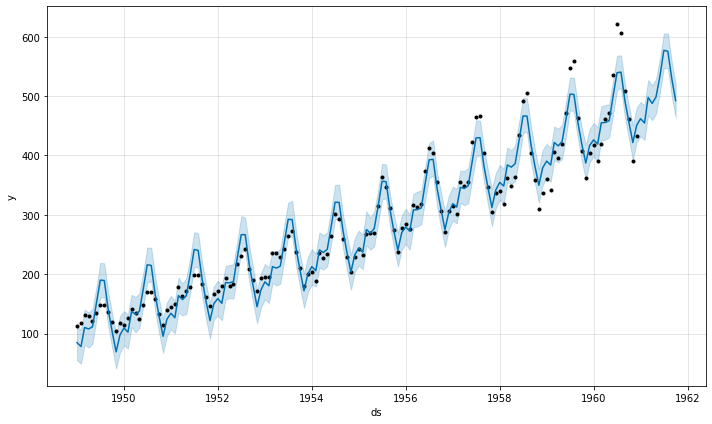

In [42]:
model.plot(forecast)
plt.show()